In [2]:
import librosa
from librosa.core import stft
from librosa.display import specshow
from librosa.feature import melspectrogram
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool

files = glob("train_audio/**/*mp3")
classes = glob("train_audio/*")
classes = [ c.split("/")[-1] for c in classes]

print(len(files))
if(len(files)==0):
    print("*** Warning *** \n No files returned \n Maybe you need a different path in glob()")


21375

# Multiprocessing
Reading files from disk is comparatively very slow.   We have a lot of files to read but we also have a lot of CPU cores.  The oldschool way is to serially read them one at a time.   The new hotness is to write a function that is passed a file to read and returns the data.  Then we build (essentially) a bunch of new "computers" (technically they are separate threads).   Then we call each thread by passing it the function and the file name

In [3]:
##  DATA INGESTION

# define a function for the threaded work
def doIt(f):
    x_train=[]
    y_train =[]
    try:
        mp3, sr = librosa.load(f, sr = 22050//2)
        for i in range(0, mp3.shape[0], sr*3):
            x = mp3[i:i+sr*3]
            if(x.shape[0]== sr*3):
                x_train.append(x)
                y_train.append(classes.index(f.split("/")[-2])) # this step converts (encodes) species name to number
    except Exception as e:
        print(e)
    return x_train, y_train


# pooled data contains both x and y in a tuple (x,y)
# so we need to unpack that.  Since we have train and test pooled sets it makes sense to make this a function
def unpoolData(pooled):
    xx= []  # temporary placeholdsrs
    yy= []  # to unpack results
    for f in pooled:
        for ff in f[0]:
            xx.append(ff)
        for ff in f[1]:
            yy.append(ff)

    xx=np.array(xx)
    yy = np.array(yy)
    return xx, yy
 

if __name__ == '__main__':   # <---- this seems to be necessary to solve a scoping problem with Pool
    p = Pool(30)    # create 30 computers 
    pooled_training = p.map(doIt, files[0::12])  # send the function "doit" plus all the filenames to be processed to all the new threads
    pooled_testing  = p.map(doIt, files[1::48])  # different offset (1) and a stride that is multiple of training.   Guaranteed to be unique


x_train, y_train = unpoolData(pooled_training)
x_test, y_test = unpoolData(pooled_testing)
 

/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.


here


/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/gary/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.


In [13]:
##  DATA RESHAPING AND NORMALIZATION

x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

numclasses = max(y_train) + 1

# figure out which column is "hot"
y_onehot  = np.zeros((x_train.shape[0], numclasses))
for i, y in enumerate(y_train):
    y_onehot[i,y]=1 # set that column

x_train = x_train/np.max(x_train)
x_test = x_test/np.max(x_test)

print(x_train.shape, y_onehot.shape)
print(np.max(x_train))

### Include any special preprocessing rules here (like dropping outliers etc)

(35137, 33075, 1) (35137, 264)
1.0


In [40]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam, Adagrad

model=Sequential()
sr = 33075
model.add(Conv1D(16,3, input_shape=(sr,1), activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32,3, padding='same', activation='relu'))
model.add(MaxPooling1D(4))
model.add(Conv1D(32,3, padding='same', activation='relu'))
model.add(MaxPooling1D(4))
model.add(Conv1D(64,3, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Conv1D(128,3, activation='relu'))
model.add(Dropout(.1))
model.add(MaxPooling1D(3))
model.add(Conv1D(256,3, activation='relu'))
model.add(Dropout(.1))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(300, activation='relu'))
model.add(Dropout(.1))  
model.add(Dense(y_onehot.shape[1], activation='softmax')) # multiclass classifier vs binary classifier would use sigmoid


# because softmax we use categorical
model.compile(loss='categorical_crossentropy', optimizer=Adagrad(), metrics=['acc'])
model.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 33073, 16)         64        
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 16536, 16)         0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 16536, 32)         1568      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 4134, 32)          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 4134, 32)          3104      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 1033, 32)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 1031, 64)         

In [47]:
model.fit(x_train, y_onehot, batch_size=512, shuffle=True, verbose=False, validation_split=.2, epochs=100)

In [ ]:
# Output Metrics
How well did we do?   We need to compare all model predictions again

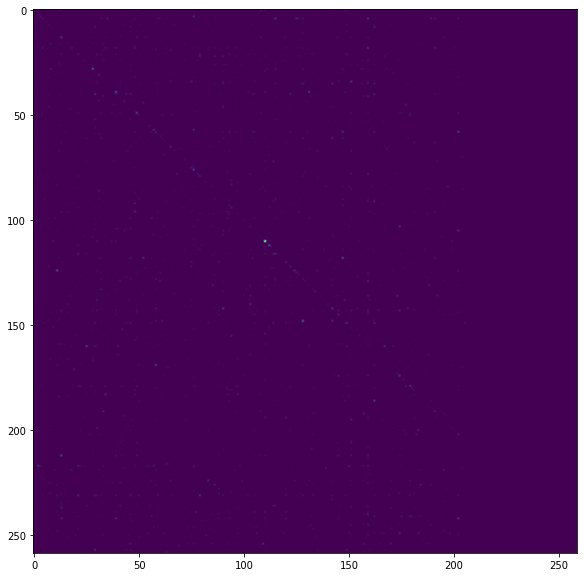

In [48]:
from sklearn.metrics import confusion_matrix

y_onehot_hat = model.predict(x_test)   

y_hat = np.argmax(y_onehot_hat, axis=1)
plt.figure(figsize=(14,10))
plt.imshow(confusion_matrix(y_test,y_hat))

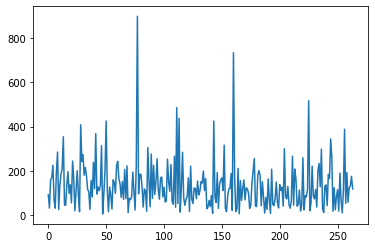

In [70]:
plt.plot(np.sum(y_onehot, axis=0))

Index:  14929
standard deviation of this clip:  0.0061500925


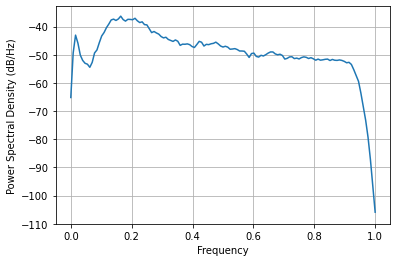

In [162]:
import IPython.display as ipd
import random

i = random.choice(range( x_train.shape[0]))
print("Index: ",i)
print("standard deviation of this clip: ", np.std(x_train[i]))

# librosa can read numpy arrays directly but I write to a file to avoid data type issues
librosa.output.write_wav("temp.wav",x_train[i], sr=22050)

# maybe the power spectral density of the clip is interesting 
plt.psd(x_train[i].ravel());
ipd.Audio("temp.wav", autoplay=True)